In [1]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

# Load in data and trained model

In [2]:
path_to_train_data = "crowd4access-images/crowd4access-images/trainval/image"
path_to_test_data = "crowd4access-images/crowd4access-images/test/image"

In [3]:
class CocoDetection(torchvision.datasets.CocoDetection):
    """
    Huge thank you to Niels Rogge, all this was written by him except for me changing filepaths
    """
    def __init__(self, img_folder: str, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [4]:
feature_extractor = DetrFeatureExtractor.from_pretrained(
    "facebook/detr-resnet-50"
    )

train_dataset = CocoDetection(img_folder=path_to_train_data, feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=path_to_test_data, feature_extractor=feature_extractor, train=False)

id2label = {k: v["name"] for k, v in train_dataset.coco.cats.items()}

model = DetrForObjectDetection.from_pretrained(
    "detr_tactile-paving"
    )
model.train(False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrTimmConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (act2): ReLU(inplace=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): DetrFrozenBatchNorm2d()
              (act3): ReLU(

# Visualize

In [126]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')

def visualize_example(threshold: float = 0.75, test_mode: bool = True):
    dataset = test_dataset if test_mode else train_dataset
    path_to_data = path_to_test_data if test_mode else path_to_train_data
    
    idx = np.random.randint(0, len(dataset))

    pixel_values, target = dataset[idx]
    pixel_values = pixel_values.unsqueeze(0)
    outputs = model(pixel_values=pixel_values, pixel_mask=None)

    image_id = target['image_id'].item()
    image = dataset.coco.loadImgs(image_id)[0]
    
    image = Image.open(os.path.join(path_to_data, image['file_name']))

    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # rescale bounding boxes
    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

    plot_results(image, probas[keep], bboxes_scaled)

/home/dadofapollo/miniconda3/envs/tactile-paving/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


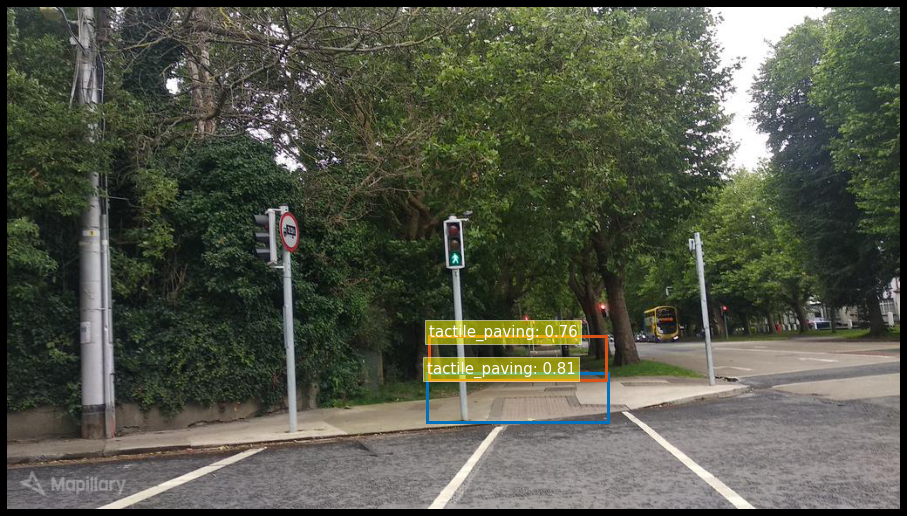

In [127]:
visualize_example()

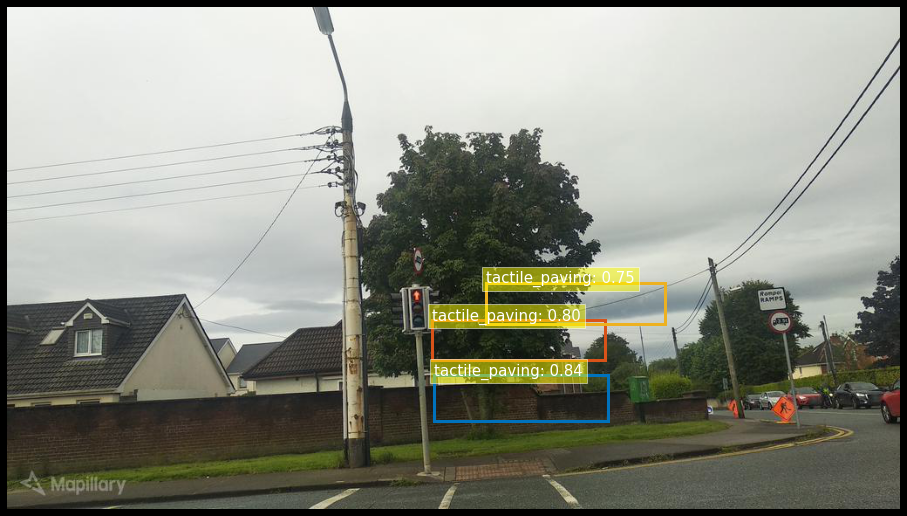

In [128]:
visualize_example()

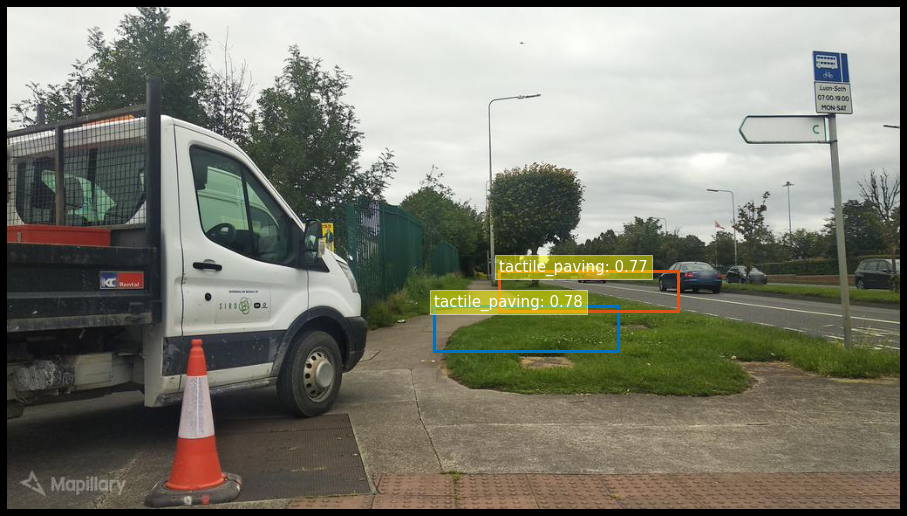

In [129]:
visualize_example()

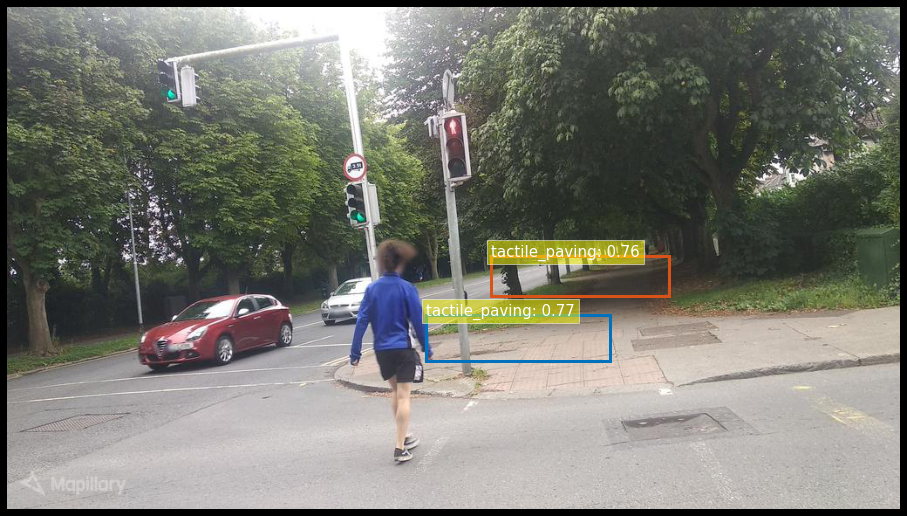

In [130]:
visualize_example()

Here we can see that the model does fine for some pictures but not others. The model did not learn the desired features of the tactile paving. More tuning can be done during model training that will increase the prediction accuracy.